<a href="https://colab.research.google.com/github/juancaalcaraz/practicaML/blob/main/AprendizageConjunto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje Conjunto.
## El objetivo de los combinado de conjuntos es combinar diferentes clasificadores en un meta-clasificador que tenga un rendimiento de generalización ,ejor que cada clasificador por separado. Un enfoque para llevar esto a cabo es mediante el voto mayoritario(Ajustes de clase binaria) y el voto pluralista(Ajustes de multiclase). Esto significa simplemente que seleccionamos la etiqueta de clase que ha sido predicha por la mayoría de los clasificadores.

## Para comparar un clasificador conjunto ideal con un clasificador básico sobre un rango de diferentes tasas de error básica, vamos a implementear la función de probabilidad en Python.  

In [2]:
from scipy.special import comb
import math

def ensemble_error(n_clasiffier, error):
  k_start = int(math.ceil(n_clasiffier/2.))
  probs = [comb(n_clasiffier, k)*error**k*(1-error)**(n_clasiffier-k) for k in range(k_start, n_clasiffier+1)]
  return sum(probs)
print(ensemble_error(11, 0.25))

0.03432750701904297


## Una ves implementada la función, podemos calcular las tasas de error conjuntas para un rango de diferentes errores básicos para visualizar la relación entre los errores básicos y conjuntos en un gráfico de líneas

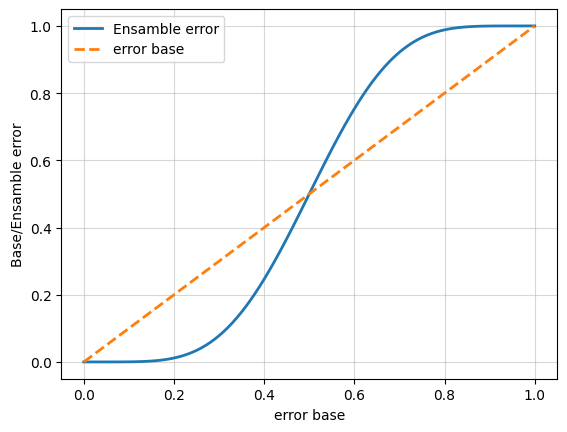

In [3]:
import numpy as np
import matplotlib.pyplot as plt
#rango de errores.
error_range = np.arange(0., 1.01, 0.01)
#error de ensamble
ens_errors = [ensemble_error(n_clasiffier=11, error= error) for error in error_range]
plt.plot(error_range, ens_errors,
         label='Ensamble error', linewidth=2)
plt.plot(error_range, error_range, linestyle='--',
         label='error base', linewidth=2)
plt.xlabel('error base')
plt.ylabel('Base/Ensamble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

## Como pudimos observar en el gráfico anterior, la probabilidad del error de un comjunto es siempre mejor que el error de un clasificador básico individual. Siempre y cuando los clasificaores funcionen mejor que la adivinación aleatoria($e$>0.5)  

In [4]:
#para ilustrar el voto mayoritario(Moda)
#utilizaremos argmax y bincount de Numpy
np.argmax(np.bincount([0, 0, 1], weights=[0.2, 0.2,0.6]))

1

## Utilizar la probabilidad de clases para el voto mayoritario puede ser útil si los clasificadores de nuestro conjunto estan bien calibrados. Para utilizar el voto mayoritario ponderado basado en probabilidad de clase, podemos utilizar average y argmax de la libreria NumPy

In [5]:
ex = np.array([[0.9, 0.1], [0.8, 0.2], [0.4, 0.6]])
p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
print(p)
print(np.argmax(p))

[0.58 0.42]
0


In [6]:
!pip install six

## Si juntamos todo implementamos MayorityVoteClassifier en python

In [ ]:
"""
from sklearn.base import BaseEstimator, ClassifierMixin, clone
import operator
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import Six
from sklearn.pipeline import _name_estimators

class MayorityVoteClassifier(BaseEstimator, ClassifierMixin):
  un clasificadotr de voto mayoritario
  Parameters
  ------
  classifiers: array-like, shape = [n_classifier]
  different classifiers for the ensemble

  vote : str, {'classlabel', 'Probability'}
    default: 'classlabel'
    if 'classlabel' the prediction is based on the
    argmax of class labels. else if 'probability' ,
    the argmax of the sum of probabilities is used to predict
    the class label(Recommended for calibrated classifiers)

  weights: array-like, shape=[n_classifier]
    optional, default: None
    if a list of 'int' or 'float' values are provided,
    the classsifier are weighted by importance;
    Uses uniform weights if 'weights=None'

  def __init__(self, classifiers, vote="classlabel", weights=None):
    self.classifiers = classifiers
    self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
    self.vote = vote
    self.weights = weights

  def fit(self, X, y):

    self.lablenc_= LabelEncoder()
    self.lablenc_.fit(y)
    self.classes_ = self.lablenc_.classes_
    self.classifiers = []
    for clf in self.classifiers:
      fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
      self.classifiers_.append(fitted_clf)
    return self

  def predict(self, X):
    if self.vote == 'probability':
      maj_vote = np.argmax(self.predict_proba(X), axis=1)
    else : #voto classlabel
        #Toma los resultados de clf.predict calls
      predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
      maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=self.weights)), axis=1, arr=predictions)
    maj_vote = self.lablenc_.inverse_transform(maj_vote)
    return maj_vote

  def predict_proba(self, X):
    probas = np.asarray([clf.predict_proba(x) for clf in self.classifers_])
    avg_proba = np.average(probas, axis=0, weights=self.weights)
    return avg_proba
  def get_params(self, deep=True):

    if not deep:
      return super(MayorityVoteClassifier, self).get_params(deep=False)
    else:
      out = self.named_classifiers.copy()
      for name, step in Six.iteritems(self.named_classifiers):
        for key, value in Six.iteritems(step.get_params(deep=True)):
          out['%s__%s'%(name, key)]=value
      return out
"""

In [8]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import _name_estimators
import numpy as np
import inspect

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=self.weights)), axis=1,
                                            arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in inspect.signature(step.get_params).parameters.items():
                    out['%s__%s' % (name, key)] = value
            return out


In [9]:
#Voto Mayoritario para hacer predicción.
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)


In [10]:
#Dividimos el dataset en entrenamiento y prueba.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

In [18]:
#vamos a entrenar 3 clasificadores disitintos con el conjunto de entrenamiento.
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np
clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=42)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=42)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])
clf_labels = ['Regresión logística', 'Árbol de decisiones', 'KNN']
print('10 carpetas de validación cruzada: \n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
  scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
  print('ROC AUC: %0.2f (+/- %0.2f) [%s]'% (scores.mean(), scores.std(),label))

10 carpetas de validación cruzada: 

ROC AUC: 0.95 (+/- 0.11) [Regresión logística]
ROC AUC: 0.97 (+/- 0.07) [Árbol de decisiones]
ROC AUC: 0.88 (+/- 0.10) [KNN]


In [19]:
#Ahora vamos a combinar los clasificadores.
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels+=['Voto mayoritario']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
  scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
  print('Precisión: %0.2f (+/- %.2f) [%s]'%(scores.mean(), scores.std(), label))

Precisión: 0.95 (+/- 0.11) [Regresión logística]
Precisión: 0.97 (+/- 0.07) [Árbol de decisiones]
Precisión: 0.88 (+/- 0.10) [KNN]
Precisión: 1.00 (+/- 0.00) [Voto mayoritario]


## Evaluar y ajustar el clasificador conjunto
### Vamos a calcular las curvas ROC a partir de los conjuntos de prueba para comprobar que mayorityVoteClassifier generaliza bien con datos no vistos.

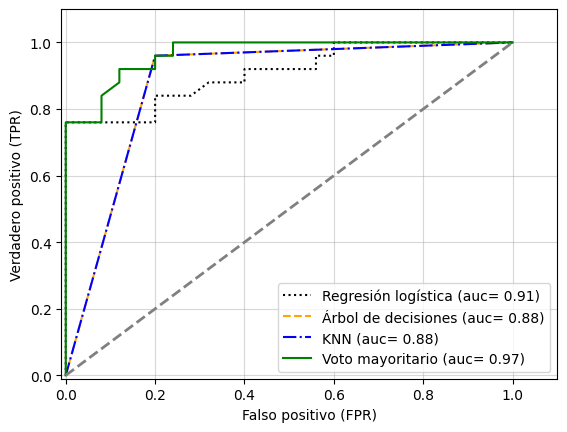

In [21]:
from sklearn.metrics import roc_curve, auc
colors = ['black','orange','blue','green']
linestyle=[':','--','-.','-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyle):
  #suponemos que la etiqueta de la clase positiva es 1
  y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
  fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
  roc_auc = auc(x=fpr, y=tpr)
  plt.plot(fpr,tpr, color=clr, linestyle=ls, label='%s (auc= %.2f)'%(label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0,1], [0,1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-.01, 1.1])
plt.ylim([-.01, 1.1])
plt.grid(alpha=.5)
plt.xlabel('Falso positivo (FPR)')
plt.ylabel('Verdadero positivo (TPR)')
plt.show()

### Como podemos ver en el ROC resultante el clasificador de voto mayoritario también funciona bien en el conjunto de prueba(ROC AUC = 0.97)